In [2]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")

from domainbed.codeplot import spider, plot
spider.plt.style.use('default')
sys.path.append("/data/rame/logs_experiments_notebook/")

In [3]:
# from captioning import fts_spider

In [4]:
from captioning import fts_spidercider as fts_spider

In [5]:
dict_clean_labels = {
    "ROUGE_L": r"$ROUGE$",
    "Bleu_1": r"$BLEU1$",
    "Bleu_4": r"$BLEU4$",
    "METEOR": r"$METEOR$",
    "CIDEr": r"$CIDEr$"
}

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']
markers = ['o', 'v', '^', '<', '>', '*', 's', 'p', 'h', 'H']

dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)

In [6]:
import math

labels = [
    "Bleu_1",
    "Bleu_4",
    "ROUGE_L",
    "METEOR",
    "CIDEr",
]

def get_minmax(list_ls):
    dict_key_to_minmax = {label: [math.inf, -math.inf] for label in labels}
    for line in list_ls:
        for key in dict_key_to_minmax:
            dict_key_to_minmax[key][0] = min(dict_key_to_minmax[key][0], line[key])
            dict_key_to_minmax[key][1] = max(dict_key_to_minmax[key][1], line[key])
    # for key in dict_key_to_minmax.keys():
    #     dict_key_to_minmax[key].append(dict_key_to_minmax[key][1] - dict_key_to_minmax[key][0])
    return dict_key_to_minmax

dict_key_to_minmax = get_minmax(fts_spider.l.values())

In [12]:
keys = [
    "bleu1", "bleu4", "rouge", "meteor", "cidere2e", "multi", "bleu_rouge_meteor_bleu4_cidere2e"
]

line_labels = [r"RL: $BLEU1$", r"RL: $BLEU4$", r"RL: $ROUGE$", r"RL: $METEOR$",
               r"RL: $CIDEr$", r"MORL: $\frac{BLEU1 + BLEU4 + ROUGE + METEOR + CIDEr}{5}$",
               "RS: uniform WA of 5 RLs"]

_colormaps = ["Blues", "Dark_Blues", "Reds", "Oranges", "Purples", "Yellows", "Greens"]
colors = [plot.get_color_from_cmap(cmap, dict_colormaps) for cmap in _colormaps]

In [13]:
data = [[fts_spider.l[key][label] for label in labels] for key in keys]


In [14]:
data

[[0.8497, 0.4086, 0.6038, 0.299, 1.3707],
 [0.8252, 0.4224, 0.6072, 0.3017, 1.3703],
 [0.8234, 0.4187, 0.61, 0.3011, 1.3701],
 [0.7838, 0.3674, 0.5994, 0.3117, 1.3168],
 [0.8321, 0.4168, 0.6059, 0.3036, 1.3965],
 [0.8333, 0.4171, 0.6072, 0.3037, 1.3855],
 [0.8364, 0.4189, 0.6092, 0.3054, 1.3897]]

In [15]:
dict_index_to_minmax = {i: dict_key_to_minmax[labels[i]] for i in range(len(labels))}
list_minmax = [dict_key_to_minmax[labels[i]] for i in range(len(labels))]

[0.0, 72.0, 144.0, 216.0, 288.0]


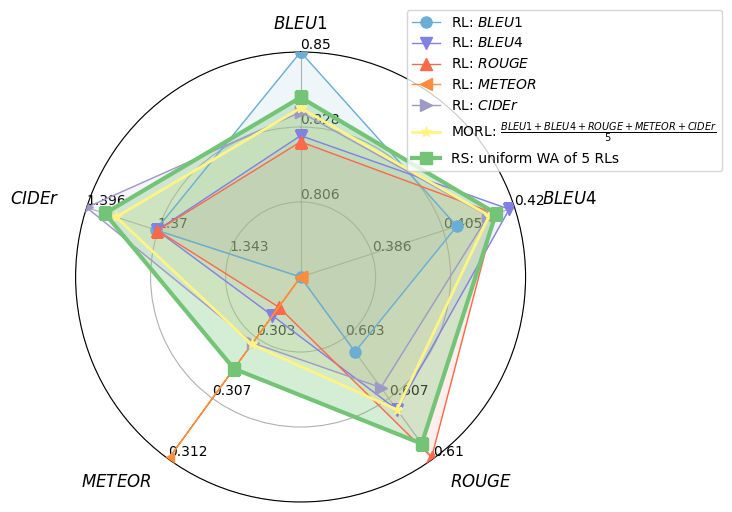

In [16]:
import pandas as pd

ranges = list_minmax

clean_labels = []
result = pd.DataFrame.from_records(
    data, columns=[dict_clean_labels.get(label, label) for label in labels]
)

variables = result.columns

fig1 = spider.plt.figure(figsize=(5, 5))
radar = spider.ComplexRadar(fig1, variables, ranges, show_scales=True, n_ring_levels=4)

for g in result.index:
    is_main = (g == (len(keys) - 1))
    is_second = (g == (len(keys) - 2))
    radar.plot(
        result.loc[g].values,
        label=line_labels[g],
        color=colors[g],
        marker=markers[g],
        markersize=8,
        linewidth=3 if is_main else (2 if is_second else 1)
    )
    radar.fill(result.loc[g].values, alpha=0.3 if is_main else (0.2 if is_second else 0.1), color=colors[g])

# radar.set_title("Radar chart solution with different scales")
radar.use_legend(loc='lower left', bbox_to_anchor=(0.72, 0.72), fontsize="medium")
spider.plt.show()

plot.save_fig(fig=fig1, name="captioning/spider_captioning.pdf", do_save=True)


In [ ]:
fig = spider.create_spider_chart(
    data=data,
    labels=labels,
    line_labels=line_labels,
    colors=colors,
    markers=markers,
    # title="Spider map",
    title=None,
    dict_clean_labels=dict_clean_labels,
    dict_key_to_minmax=dict_key_to_minmax,
    num_ticks=5,
    legend_loc=(1.05, 1.0))